In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch


image = cv2.imread('1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))   

In [3]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_b_01ec64.pth"
model_type = "vit_b"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)

predictor = SamPredictor(sam)

In [4]:
predictor.set_image(image)

In [5]:
input_point = np.array([[150, 150]])
input_label = np.array([0])

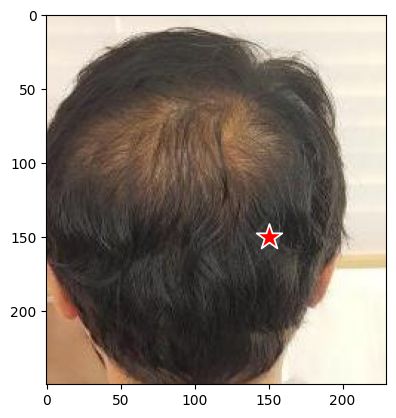

In [6]:
# plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

In [7]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

In [8]:
masks.shape

(3, 250, 230)

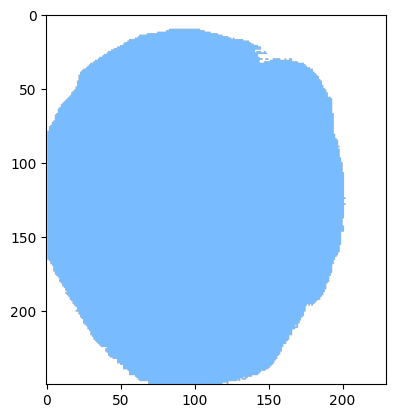

In [9]:
m1 = masks[0]
color = np.array([30/255, 144/255, 255/255, 0.6])
h, w = m1.shape[-2:]
mask_image = m1.reshape(h, w, 1) * color.reshape(1, 1, -1)
plt.imshow(mask_image)
plt.show()

In [10]:
## segmentation된 부분만 이미지에서 추출하여 저장

import numpy as np

def extract_segmented(orig_image, seg_image):
    new_shape = (250, 230, 3)
    result = np.empty(new_shape, dtype=np.uint8)
    result[..., :seg_image.shape[-1]] = seg_image[..., np.newaxis]

    result = orig_image * result
    target_color = [0, 0, 0]
    mask = np.all(result == target_color, axis=-1)
    result[mask] = [255, 255, 255]
    cv2.imwrite('2.jpg', result)

In [13]:
image1 = cv2.imread('1.jpg')
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
# image100 = cv2.imread('8.jpg')
# image100 = cv2.cvtColor(image100, cv2.COLOR_BGR2RGB)

extract_segmented(image1, masks[0])
# extract_segmented(image100, masks[0])

Percentage of skin color: 0.00%


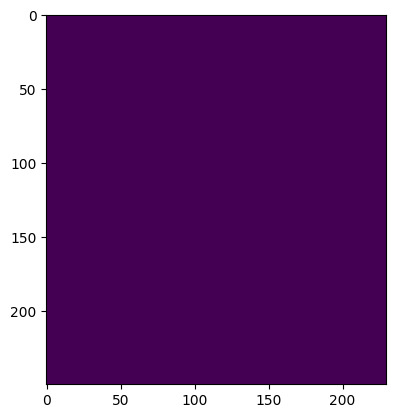

In [22]:
# 이미지에서 segmentation 부분의 color percentage 계산(skin color, black)

import cv2
import numpy as np

def calculate_color_perc(image):
    # load image
    orig_image = cv2.imread(image)

    # Convert the image to the HSV color space
    hsv_image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2HSV)

    # Define the color range for skin color in HSV
    lower_skin = np.array([0, 50, 95], dtype=np.uint8)
    upper_skin = np.array([20, 255, 255], dtype=np.uint8)

    # Create a mask for skin color
    skin_mask = cv2.inRange(hsv_image, lower_skin, upper_skin)

    # Calculate the percentage of blackish color and skin color
    total_pixels = orig_image.shape[0] * orig_image.shape[1]
    percentage_skin = (np.count_nonzero(skin_mask) / total_pixels) * 100

    print(f"Percentage of skin color: {percentage_skin:.2f}%")
    plt.imshow(skin_mask)
    plt.show()

    # fig, ax = plt.subplots(1, 2)
    # ax[0].imshow(orig_image)
    # ax[1].imshow(skin_mask)
    # plt.show()

calculate_color_perc('2.jpg')